# Create frequent public transport stops analysis


This notebook describes a process to retain public transit stops points with frequent services

### Method: Stop headway analysis using average frequencies of departure during day time

- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during daytime over departure for normal weekdays
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)


### Process:
1. set up study region GTFS analysis parameters (gtfs_config.py)  
2. load GTFS data into an UrbanAccess transit data frame  
3. select a usual or representative one week during the feeds period that should fully capture the provided PT services in a city. 
    - a suitable "usual" week should contain at least 0.9 (default) of the total maximum of trips.
4. Stop headway analysis using average departure time during usual weekday (Monday-Friday) daytime (7am-7pm)


Previous working branch using SQL:

https://github.com/shiqin-liu/global-indicators/blob/phoenix/process/07_create_frequent_public_transport.ipynb  


In [ ]:
#For UrbanAccess installation instructions see: https://udst.github.io/urbanaccess/installation.html

In [23]:
#conda install -c udst urbanaccess

In [24]:
import pandas as pd
import geopandas as gpd
import os
import time   
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt

import calendar
import datetime
from datetime import timedelta


import urbanaccess as ua

# module with functions to load GTFS data into dataframes
# revise based on origional load function from UrbanAccess, take out the add agency and route type features
import ua_load 

# module with functions to calculate the average headway during the timeframe over departure
import gtfs_headway_analysis as gha

from shapely.geometry import shape,Point, LineString, Polygon

%matplotlib inline


In [25]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [3]:
# get lat lon bounding box for each study region
# for plotting
for layer in ['Buffered Adelaide', 'Buffered Melbourne', 'Buffered Sydney']:
    crs = 'epsg:7845'
    # load shapefile
    shape = gpd.GeoDataFrame.from_file('gtfs_input_data/Australian stops for reference/gtfs_2020_02_14_headway_au_global_indicators.gpkg', 
                  layer=layer)
    # create buffer
    polygon = shape['geometry'].iloc[0]
    polygon_proj = ox.project_geometry(polygon, crs=crs, to_crs=None, to_latlong=True)
    # get bounding box
    bbox = polygon_proj[0].bounds
    print(layer, ' : ', bbox)
    
#minx , miny , maxx , maxy

Buffered Adelaide  :  (138.46098212857206, -35.15966609024628, 138.74830806651352, -34.71454282915053)
Buffered Melbourne  :  (144.59067957842007, -38.21131973169178, 145.39847326519424, -37.61837232908795)
Buffered Sydney  :  (150.6290606117829, -34.12321411958463, 151.3206735172292, -33.66275213092711)


In [4]:
# set up study region GTFS config
# these gtfs parameters are defined in gtfs_config.py file
GTFS = {'adelaide':{'gtfs_filename':'gtfs_input_data/gtfs_au_sa_adelaidemetro_20191004',
                    'gtfs_provider' : 'Adelaide Metro',
                    'gtfs_year' : '2019',
                    # define month and day for feeds start and end date
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                    # get bounding box from study region boundary shapefile
                    # bounding box formatted as a 4 element tuple: (lng_max, lat_min, lng_min, lat_max)
                    # you can generate a bounding box by going to http://boundingbox.klokantech.com/ and selecting the CSV format.
                    # this parameters is optional, for use if wanting remove features outside the bbox when loading feeds
                    'bbox' : (138.46098212857206, -35.15966609024628, 138.74830806651352, -34.71454282915053), 
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'bus' : {'route_types': [3],
                                  'peak_time' : ['07:00:00', '09:00:00'], 
                                  'day_time' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': None},
                        'tram':{'route_types': [0], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'train':{'route_types': [1,2], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'ferry':{'route_types': [4], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None}
                    }
                   },
        'melbourne':{'gtfs_filename':'gtfs_input_data/gtfs_au_vic_ptv_20191004',
                    'gtfs_provider' : 'Public Transport Victoria',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                     'bbox' : (144.59067957842007, -38.21131973169178, 145.39847326519424, -37.61837232908795),
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'bus' : {'route_types': [3],
                                  'peak_time' : ['07:00:00', '09:00:00'], 
                                  'day_time' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': [4, 6]},
                        'tram':{'route_types': [0], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': [3]},
                        'train':{'route_types': [1,2], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': [1,2]}

                    }
                   },
        'sydney' : {'gtfs_filename':'gtfs_input_data/gtfs_au_nsw_tfnsw_complete_20190619',
                    'gtfs_provider' : 'Transport for NSW',
                    'gtfs_year' : '2019',
                    # define month and day for "representative period" ie. not in school time
                    'start_date_mmdd' : '20191008', 
                    'end_date_mmdd' : '20191205',
                    'bbox' : (150.6290606117829, -34.12321411958463, 151.3206735172292, -33.66275213092711),
                    # define modes for GTFS feed(s) as per agency_id codes in agency.txt below
                    'modes' : {
                        'bus' : {'route_types': [700,712,714],
                                  'peak_time' : ['07:00:00', '09:00:00'], 
                                  'day_time' : ['07:00:00', '19:00:00'],
                                  'intervals': 30,
                                 'agency_id': None},
                        'tram':{'route_types': [0], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},
                        'train':{'route_types': [2,401], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None},

                        'ferry':{'route_types': [4], 
                                'peak_time' : ['07:00:00', '09:00:00'],
                                'day_time' : ['07:00:00', '19:00:00'],
                                'intervals': 30,
                                'agency_id': None}
                    }
                   }
       }
                    



In [5]:
# set up a study region config to run in this notebook
city = 'adelaide'

gtfsfeed_path = GTFS['{}'.format(city)]['gtfs_filename']
start_date=GTFS['{}'.format(city)]['start_date_mmdd']
end_date=GTFS['{}'.format(city)]['end_date_mmdd']

peak_hour = GTFS['{}'.format(city)]['modes']['bus']['day_time']
start_hour = peak_hour[0]
end_hour = peak_hour[1]


headway_intervals = GTFS['{}'.format(city)]['modes']['bus']['intervals']
route_types = GTFS['{}'.format(city)]['modes']['bus']['route_types']
agency_ids = GTFS['{}'.format(city)]['modes']['bus']['agency_id']

shape_layer_name = 'Buffered Adelaide'


# Load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Loading GTFS data into a UrbanAccess transit data object


In [6]:
# revise based on origional function from UrbanAccess, take out the add agency and route type features
loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path)

--------------------------------
GTFS text file header whitespace check completed. Took 4.27 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 3.52 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_sa_adelaidemetro_20191004
     Took 9.75 seconds


### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

Quickly view the transit stop locations

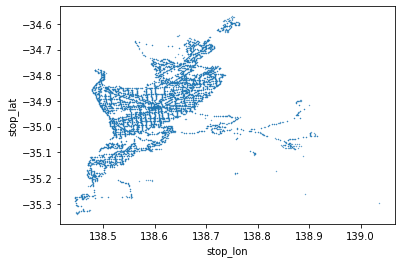

In [7]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)


# Select usual and representative one week for feeds analysis


In [9]:
from gtfs_headway_analysis import set_date_service_table

# Get trip counts per day between the start and end day of the feed.
def get_trip_counts_per_day(loaded_feeds):
    """
    Get trip counts per day between the start and end day of the feed.
    
    Parameters
    ----------
    loaded_feeds: gtfsfeeds_dataframe with GTFS objects
   
   Returns
    -------
    daily_trip_counts : pandas.DataFrame
        Has columns "date" and "trip_counts"
    """
    date_service_df = set_date_service_table(loaded_feeds)
    daily_trip_counts = pd.merge(date_service_df, loaded_feeds.trips, on='service_id').groupby(['date'
                                                    ], sort=False)['trip_id'].count().to_frame('trip_counts')
    daily_trip_counts = daily_trip_counts.sort_index().reset_index()
    return daily_trip_counts


In [10]:
# function revised from gtfspy (reference:https://www.nature.com/articles/sdata201889#Sec21):
# https://github.com/CxAalto/gtfspy/blob/47f1526fee43b83b396c7e75b64a4b9de3b467a0/gtfspy/gtfs.py#L679
def get_weekly_extract_start_date(daily_trip_counts, weekdays_at_least_of_max=0.9,
                                start_date=None):
    """
    Find a suitable weekly extract start date (monday).
    The goal is to obtain as 'usual' week as possible.
    The weekdays of the weekly extract week should contain
    at least 0.9 (default) of the total maximum of trips.
    
    Parameters
    ----------
    daily_trip_counts: pandas.DataFrame
        Has columns "date" and "trip_counts"
    
    weekdays_at_least_of_max: float
    
    start_date: str, semi-optional
        start_date in format %Y-%m-%d, weeks close to this.
        if given, overrides the recorded start date in the feed
    
    Returns
    -------
    row['date']: int or str or Timestamp
    
    """
    
    # make sure the daily trip count is sorted by date 
    daily_trip_counts = daily_trip_counts.sort_values('date').reset_index()
    # search start date, defaults to the smallest date in the feed
    if isinstance(start_date, str):
        search_start_date = datetime.datetime.strptime(start_date, "%Y%m%d")
    elif isinstance(start_date, datetime.datetime):
        search_start_date = start_date
    else:
        assert start_date is None
        warnings.warn("Download date is not speficied in the database, defaults to the smallest date when any operations take place.")
        search_start_date = daily_trip_counts['date'].min()
    
    feed_min_date = daily_trip_counts['date'].min()
    feed_max_date = daily_trip_counts['date'].max()
    
    assert (feed_max_date - feed_min_date >= datetime.timedelta(days=7)), \
    "Dataset is not long enough for providing week long extracts"
    
    # get first a valid monday where the search for the week can be started:
    next_monday_from_search_start_date = search_start_date + timedelta(days=(7 - search_start_date.weekday()))
    
    if not (feed_min_date <= next_monday_from_search_start_date <= feed_max_date):
        warnings.warn("The next monday after the (possibly user) specified download date is not present in the database."
                  "Resorting to first monday after the beginning of operations instead.")
        next_monday_from_search_start_date = feed_min_date + timedelta(days=(7 - feed_min_date.weekday()))
    
    # Take 95th percentile to omit special days, if any exist.
    max_trip_count = daily_trip_counts['trip_counts'].quantile(0.95)

    threshold = weekdays_at_least_of_max * max_trip_count
    threshold_fulfilling_days = daily_trip_counts['trip_counts'] > threshold

    # look forward first
    # get the index of the trip:
    search_start_monday_index = daily_trip_counts[daily_trip_counts['date'] == next_monday_from_search_start_date].index[0]
    
         # get starting point
    while_loop_monday_index = search_start_monday_index
    while len(daily_trip_counts.index) >= while_loop_monday_index + 7:
        if all(threshold_fulfilling_days[while_loop_monday_index:while_loop_monday_index + 5]):
            row = daily_trip_counts.iloc[while_loop_monday_index]
            #return row['date']
        while_loop_monday_index += 7

    while_loop_monday_index = search_start_monday_index - 7
    # then backwards
    while while_loop_monday_index >= 0:
        if all(threshold_fulfilling_days[while_loop_monday_index:while_loop_monday_index + 5]):
            row = daily_trip_counts.iloc[while_loop_monday_index]
            #return row['date']
        while_loop_monday_index -= 7
        
    return row['date']

    

In [11]:
# drive usual week starting Monday
# ensured that all weekdays have at least 90% of the maximum number of 
# daily PT trips during the time span of the week-long extract.
daily_trip_counts = get_trip_counts_per_day(loaded_feeds)
usual_start_date = get_weekly_extract_start_date(daily_trip_counts, weekdays_at_least_of_max=0.9, start_date=start_date)
usual_start_date

Timestamp('2019-12-02 00:00:00')

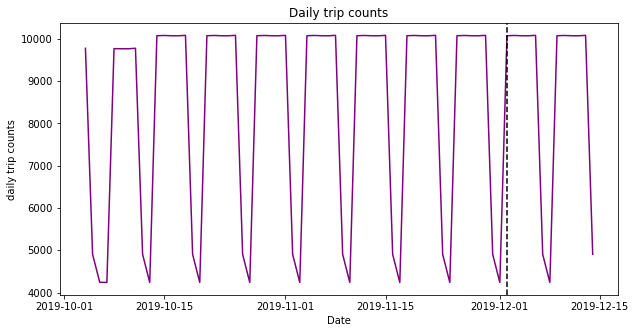

In [12]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 5))

# Add x-axis and y-axis
ax.plot(daily_trip_counts.sort_values('date')['date'],
        daily_trip_counts.sort_values('date')['trip_counts'],
        color='purple')

plt.axvline(x=usual_start_date, color='k', linestyle='--')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="daily trip counts",
       title="Daily trip counts")

plt.show()

Reference: [Kujala et. al. (2018) A collection of public transport network data sets for 25 cities](https://www.nature.com/articles/sdata201889#Sec21)  
"The dates for the temporal filtering were chosen based on the number of daily trips of the included feeds. We ensured that there was a clear weekly periodicity in the feeds, so that working days have roughly the same number of trips and that weekends have a different schedule. Then we selected the dates for the week-long and day-long extracts, where we aimed for a typical work week without major exceptions in the PT operations, such as national holidays. To this end, we ensured that all weekdays have at least 90% of the maximum number of daily PT trips during the time span of the week-long extract."

# Stop headway analysis using average departure time dur weekday daytime

- Identify feeds start and end dates that that a stop is a 30-minute frequency stop  
- group by service date, then count the frequencies of departure for each stop
- calculate the average headway during the timeframe over departure
- approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html)

In [13]:
# set the start and end date to usual week of weekday operation (Monday to Friday)
start_date = usual_start_date
end_date = usual_start_date + timedelta(4)

In [14]:
stops_headway = gha.get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date, 
                           end_date, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday'])

/home/jovyan/work/process/GTFS_freq_stop/gtfs_headway_analysis.py:273: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()


In [15]:
# select average departure headway less than or equal to maxi headway frequency intervals
stop_30_mins_headway = stops_headway[stops_headway['headway'] <= 20]

# get spatial features for freqent stops
stop_30_mins_final = pd.merge(stop_30_mins_headway, loaded_feeds.stops, how='left', on='stop_id')

# add stop id geometry
stop_30_mins_final['geometry'] = stop_30_mins_final.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_30_mins_final = gpd.GeoDataFrame(stop_30_mins_final)

In [16]:
len(stop_30_mins_final)

2673

# Plot all PT stop and freqent PT bus stops

In [17]:
# get the study region boundary gdf
shape = gpd.GeoDataFrame.from_file('gtfs_input_data/Australian stops for reference/gtfs_2020_02_14_headway_au_global_indicators.gpkg', 
                  layer=shape_layer_name)

polygon = shape['geometry'].iloc[0]
crs = shape.crs

polygon_proj = ox.project_geometry(polygon, crs=crs, to_crs=None, to_latlong=True)
shape_proj = gpd.GeoDataFrame(polygon_proj[0]).rename(columns={0:'geometry'})
shape_proj = gpd.GeoDataFrame(shape_proj,  geometry='geometry')

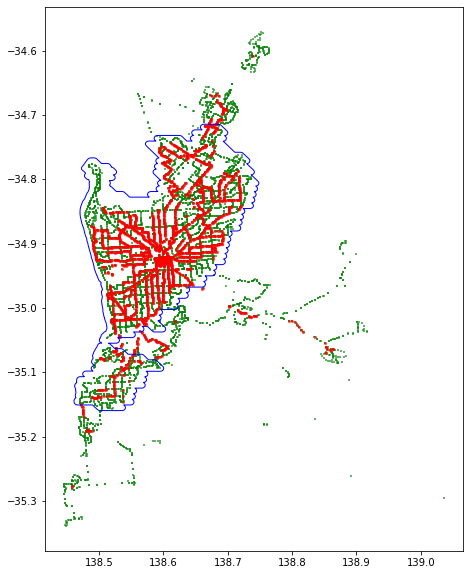

In [18]:
# set spatial geometry for all stops 
loaded_feeds.stops['geometry'] = loaded_feeds.stops.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
all_stops_gdf = gpd.GeoDataFrame(loaded_feeds.stops)

# plot the stops
fig, ax = plt.subplots(figsize=(10, 10))
ax = all_stops_gdf.plot(ax=ax, color='green', marker='+', markersize=5, alpha=0.6)
ax = stop_30_mins_final.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5)
ax = shape_proj.plot(ax=ax, color='none', edgecolor='blue')

#ax.set_axis_off()

plt.show()

In [19]:
# select stops within study region boundary
len(stop_30_mins_final[(stop_30_mins_final.within(polygon_proj[0]))])

2496

In [20]:
# all stops within study region boundary
len(all_stops_gdf[(all_stops_gdf.within(polygon_proj[0]))])

6198

# Run all cities GTFS frequent stop analysis
TODO: move to a python script file (done)

In [21]:
[list(GTFS.keys())[0]]

['adelaide']

In [26]:
# get the work directory
dirname = os.path.abspath('') 

# geopackage path where to save processing layers
gpkgPath_output = os.path.join(dirname, 'frequent_transit_headway_2020May_python.gpkg')


for city in [list(GTFS.keys())[0]]:
    #print(city)
    city_config = GTFS['{}'.format(city)]
    gtfsfeed_path = city_config['gtfs_filename']
    start_date = city_config['start_date_mmdd']
    end_date = city_config['end_date_mmdd']
    authority = city_config['gtfs_provider']
    hour = 'day_time'
    
    # load GTFS Feed
    loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path)
    
    stop_frequent = pd.DataFrame()
    for mode in city_config['modes'].keys():
        startTime = time.time()
        print('Start to process {} {} analysis during {}'.format(city, mode, hour))

        hour_1 = city_config['modes']['{}'.format(mode)]['{}'.format(hour)]
        start_hour = hour_1[0]
        end_hour = hour_1[1]

        headway_intervals = city_config['modes']['{}'.format(mode)]['intervals']
        route_types = city_config['modes']['{}'.format(mode)]['route_types']
        agency_ids = city_config['modes']['{}'.format(mode)]['agency_id']
        
        #count trips per day
        daily_trip_counts = get_trip_counts_per_day(loaded_feeds)
        #derive a usual week for frequency analysis
        usual_start_date = get_weekly_extract_start_date(daily_trip_counts, weekdays_at_least_of_max=0.9, 
                                                         start_date=start_date)
        
        # set the start and end date to usual week of weekday operation (Monday to Friday)
        start_date_usual = usual_start_date
        end_date_usual = usual_start_date + timedelta(4)

        stops_headway = gha.get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date_usual, 
                           end_date_usual, route_types, agency_ids, 
                           dow=['monday','tuesday','wednesday','thursday','friday'])

        if len(stops_headway) > 0:
            stop_frequent_final = pd.merge(stops_headway, loaded_feeds.stops, how='left', on='stop_id')
            stop_frequent_final['authority'] = authority
            stop_frequent_final['mode'] = mode
            stop_frequent = stop_frequent.append(stop_frequent_final)
            print('     Complete {} ({}) {} during {} with {} stop counts in {:,.2f} seconds'.format(
                city, authority, mode, hour, len(stops_headway), time.time() - startTime))
        else:
            print('     {} {} feature is found in {} ({}) during {} \n'.format(
                len(stops_headway), mode, city, authority, hour))
            continue

    # get spatial features for freqent stops
    # add stop id geometry
    stop_frequent['geometry'] = stop_frequent.apply(
        lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
    stop_frequent_gdf = gpd.GeoDataFrame(stop_frequent)
    
    # show frequent stop stats
    tot_df = stop_frequent_gdf.groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'tot_stops'})
    headway30_df = stop_frequent_gdf[stop_frequent_gdf['headway']<=30].groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'headway<=30'})
    headway20_df = stop_frequent_gdf[stop_frequent_gdf['headway']<=20].groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'headway<=20'})
    
    mode_freq_comparison = pd.concat([tot_df, headway30_df, headway20_df], axis=1)
    mode_freq_comparison['pct_headway<=30'] = (mode_freq_comparison['headway<=30']*100 / mode_freq_comparison['tot_stops']).round(2) 
    mode_freq_comparison['pct_headway<=20'] = (mode_freq_comparison['headway<=20']*100 / mode_freq_comparison['tot_stops']).round(2) 
    display(mode_freq_comparison)
    
    # save to output file
    # save the frequent stop by study region and modes to a new layer in geopackage
    stop_frequent_gdf.to_file(
        gpkgPath_output,
        layer='{}_{}min_stops_{}_{}_{}'.format(
            city, headway_intervals, hour, start_date, end_date),
        driver='GPKG')



--------------------------------
GTFS text file header whitespace check completed. Took 5.94 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 4.47 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_sa_adelaidemetro_20191004
     Took 16.50 seconds
Start to process adelaide bus analysis during day_time


/home/jovyan/work/process/GTFS_freq_stop/gtfs_headway_analysis.py:273: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  & (date_service_df['date'] <= end_date_mmdd)].drop_duplicates()


     Complete adelaide (Adelaide Metro) bus during day_time with 7352 stop counts in 2.32 seconds
Start to process adelaide tram analysis during day_time
     Complete adelaide (Adelaide Metro) tram during day_time with 62 stop counts in 0.63 seconds
Start to process adelaide train analysis during day_time
     Complete adelaide (Adelaide Metro) train during day_time with 173 stop counts in 0.53 seconds
Start to process adelaide ferry analysis during day_time
     0 ferry feature is found in adelaide (Adelaide Metro) during day_time 



,tot_stops,headway<=30,headway<=20,pct_headway<=30,pct_headway<=20
mode,,,,,
bus,7352,5228,2673,71.11,36.36
train,173,169,75,97.69,43.35
tram,62,62,62,100.00,100.00
